# Autoregressive Residual Neural Network

This notebook is a JAX implementation of the Autoregressive Residual Neural Network model to solve the Kuramoto-Sivashinsky equation. The code combines the autoregressive model with the residual neural network to solve the Kuramoto-Sivashinsky equation.

## Importing the necessary libraries

In [1]:
import jax 
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from tqdm.autonotebook import tqdm

/var/folders/1z/t07mkwr55sqbw9ld5m6_dhvm0000gn/T/ipykernel_30777/4237195013.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Seting the constants

In [2]:
DOMAIN_SIZE = 100.00
NUM_DOF = 256
DT = 0.2

NUM_SAMPLES_TRAIN = 60
TRAIN_TEMPORAL_HORIZON = 100
NUM_WARMUP_STEPS = 800

NUM_SAMPLES_TEST = 30
TEST_TEMPORAL_HORIZON = 200

## Creating the dataset

The KS dataset will come from the notebook file 'DataGenerator.ipynb'.

In [3]:
# Create the class to solve the KS equation
class KsEtd2():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

In [4]:
ks_etdrk2_stepper = KsEtd2(DOMAIN_SIZE, NUM_DOF, DT)

In [5]:
u_0 = jax.random.normal(jax.random.PRNGKey(0), (NUM_SAMPLES_TRAIN,1,NUM_DOF))

u_0 = jax.vmap(lambda u: u - jnp.mean(u))(u_0) 

In [6]:
def rollout(
        stepper_fn,
        n,
        *,
        include_init = False,
    ):

    """Transform an autonomous timestepper into a function that efficiently unrolls a trajectory."""
    def scan_fn(u, _):
        u_next = stepper_fn(u)
        return u_next, u_next

    def rollout_fn(init):
        _,history = jax.lax.scan(scan_fn, init, None, length=n)

        if include_init:
            return jnp.concatenate([init[None], history], axis=0)
        else:
            return history
    
    return rollout_fn
    

In [7]:
trj_with_warmpu = jax.vmap(rollout(ks_etdrk2_stepper, TRAIN_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, include_init=True))(u_0)

trj_with_warmpu.shape

(60, 901, 1, 256)

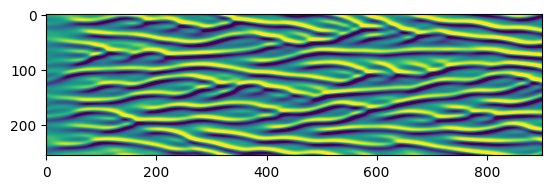

In [8]:
plt.imshow(trj_with_warmpu[0,:,0,:].T, cmap='viridis',vmin=-2,vmax=2)

(60, 101, 1, 256)


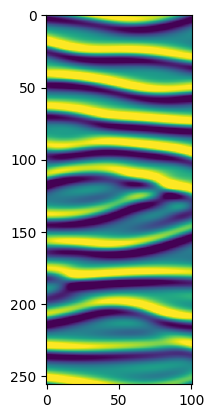

In [9]:
trj = trj_with_warmpu[:,NUM_WARMUP_STEPS:,:,:]

plt.imshow(trj[0,:,0,:].T, cmap='viridis',vmin=-2,vmax=2)
print(trj.shape)


In [10]:
u_0_teste = jax.random.normal(jax.random.PRNGKey(0), (NUM_SAMPLES_TEST,1,NUM_DOF))

u_0_teste = jax.vmap(lambda u: u - jnp.mean(u))(u_0_teste)

u_0_teste.shape

(30, 1, 256)

In [11]:
trj_test = jax.vmap(rollout(ks_etdrk2_stepper, TEST_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, include_init=True))(u_0_teste)[:,NUM_WARMUP_STEPS:]

trj_test.shape

(30, 201, 1, 256)

In [12]:
def slice_window_of_tow(one_trj):
    num_time_steps = one_trj.shape[0]

    windows = []

    for i in range(num_time_steps- 1):
        windows.append(one_trj[i:i+2]) # This part of the code make the windows of size 2

    return jnp.stack(windows)


sub_trj = jax.vmap(slice_window_of_tow)(trj)

# (NUM_SAMPLES_TRAIN, NUM_SUB-TRAJECTORIES, 2, 1, NUM_DOF)
sub_trj.shape

(60, 100, 2, 1, 256)

In [13]:
train_data = jnp.concatenate(sub_trj)

# (NUM_SAMPLES_TRAIN*NUM_SUB_TRAJECTORIES, 2, 1, NUM_DOF)
train_data.shape

(6000, 2, 1, 256)

Text(0.5, 0, 'space')

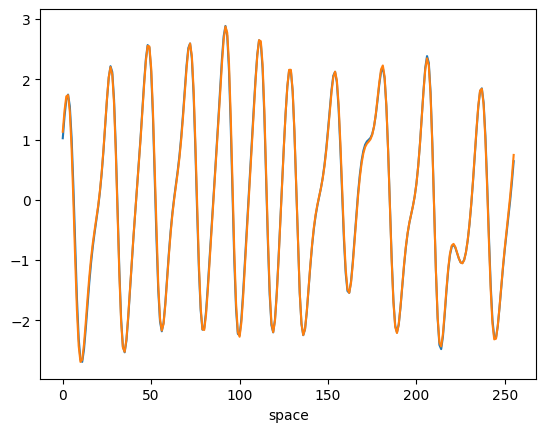

In [14]:
plt.plot(train_data[400,:,1,:].T)
plt.xlabel('space')

## Residual Neural Network

In [24]:
from typing import Callable

class ResBlockPostActivationPeriodic1d(eqx.Module):
    conv_1: eqx.nn.Conv1d # This is the first convolutional layer
    conv_2: eqx.nn.Conv1d # This is the second convolutional layer
    activation: Callable # This is the activation function, and the Callable type is a function that returns a value

    def __init__(
        self,
        hidden_channels: int,
        activation: Callable,
        *, # This is a separator to indicate that the following arguments are keyword-only
        key,
    ):
        c_1_key, c_2_key = jax.random.split(key)

        # Requires an up-to-dat version of Equinox
        self.conv_1 = eqx.nn.Conv1d( # This is the first convolutional layer
            hidden_channels, # This is the number of input channels
            hidden_channels, # This is the number of output channels
            kernel_size=3, # This is the kernel size, it means that the convolutional layer will use 3 points to make the convolution
            padding="SAME", # This is the padding, it means that the convolutional layer will use the same size of the input
            padding_mode="CIRCULAR", # This is the padding mode, it means that the convolutional layer will use the circular padding
            key=c_1_key 
        )
        self.conv_2 = eqx.nn.Conv1d(
            hidden_channels,
            hidden_channels,
            kernel_size=3,
            padding="SAME",
            padding_mode="CIRCULAR",
            key=c_2_key
        )

        self.activation = activation

    def __call__(
        self,
        x,
    ):
        x_skip = x
        x = self.conv_1(x)
        x = x + x_skip # Residual connection
        x = self.activation(x)
        x = self.conv_2(x)
        x = x + x_skip # Residual connection
        x = self.activation(x)

        return x

In [25]:
class ResNetPeriodic1d(eqx.Module):
    lifting: eqx.nn.Conv1d # This is the first layer, the lifting layer that maps the input to the hidden space of the network with upper dimension
    blocks: list[ResBlockPostActivationPeriodic1d] # This is the list of the ResNet blocks that will be used in the network.
    projection: eqx.nn.Conv1d # This is another 1D convolutional layer with kernel size 1, which projects the final transformed data back to a lower-dimensional space.

    def __init__(
        self,
        hidden_channels,
        num_blocks,
        activation,
        *,
        key,
    ):
        l_key, *block_keys, p_key = jax.random.split(key, num_blocks+2)

        self.lifting = eqx.nn.Conv1d(1, hidden_channels, kernel_size=1, key=l_key)
        self.blocks = [
            ResBlockPostActivationPeriodic1d(hidden_channels, activation, key=k)
            for k in block_keys
        ]
        self.projection = eqx.nn.Conv1d(hidden_channels, 1, kernel_size=1, key=p_key)

    def __call__(self, x):
        x = self.lifting(x)
        for block in self.blocks:
            x = block(x)
        x = self.projection(x)

        return x


In [26]:
def dataloader(
    data,
    *,
    batch_size: int,
    key,
):
    """
    Loop generator over the data. The data can be a PyTree or an Array. For
    supervised learning problems you can also hand over a tuple of Arrays
    (=PyTree).
    """

    n_samples_list = [a.shape[0] for a in jtu.tree_leaves(data)]

    if not all(n == n_samples_list[0] for n in n_samples_list):
        raise ValueError(
            "All arrays / PyTree leaves must have the same number of samples. (Leading array axis)"
        )

    n_samples = n_samples_list[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_data = jtu.tree_map(lambda a: a[batch_indices], data)

        yield sub_data

In [27]:
HIDDEN_CHANNELS = 26
NUM_BLOCKS = 5
ACTIVATION = jax.nn.relu
INIT_SEED = 42
LEARNING_RATE = 3e-4
SHUFFLE_SEED = 99
NUM_EPOCHS = 30
BATCH_SIZE = 20

ks_res_net_emulator = ResNetPeriodic1d(HIDDEN_CHANNELS, NUM_BLOCKS, ACTIVATION, key=jax.random.PRNGKey(INIT_SEED))

optimizer = optax.adam(LEARNING_RATE)

opt_state = optimizer.init(eqx.filter(ks_res_net_emulator, eqx.is_array))

def loss_fn(model, batch):
    x, y = batch[:, 0], batch[:, 1]
    y_pred = jax.vmap(model)(x)
    mse = jnp.mean(jnp.square(y_pred - y))
    return mse

@eqx.filter_jit
def step_fn(model, state, batch):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, batch)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

shuffle_key = jax.random.PRNGKey(SHUFFLE_SEED)
train_loss_history = []

for epoch in tqdm(range(NUM_EPOCHS)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in tqdm(dataloader(train_data, batch_size=BATCH_SIZE, key=subkey)):
        ks_res_net_emulator, opt_state, loss = step_fn(ks_res_net_emulator, opt_state, batch)

        train_loss_history.append(loss)

    print('Avg Loss: ', jnp.mean(loss))    

300it [00:08, 37.30it/s]0:00<?, ?it/s]
  3%|▎         | 1/30 [00:08<03:53,  8.04s/it]

Avg Loss:  0.0015732329


300it [00:06, 43.44it/s]
  7%|▋         | 2/30 [00:14<03:26,  7.38s/it]

Avg Loss:  0.0011950199


300it [00:06, 43.54it/s]
 10%|█         | 3/30 [00:21<03:13,  7.16s/it]

Avg Loss:  0.0010855462


300it [00:07, 41.03it/s]
 13%|█▎        | 4/30 [00:29<03:07,  7.22s/it]

Avg Loss:  0.0009092957


300it [00:07, 42.80it/s]
 17%|█▋        | 5/30 [00:36<02:58,  7.14s/it]

Avg Loss:  0.00092710956


300it [00:06, 43.07it/s]
 20%|██        | 6/30 [00:43<02:50,  7.08s/it]

Avg Loss:  0.0007733285


300it [00:06, 43.38it/s]
 23%|██▎       | 7/30 [00:50<02:41,  7.03s/it]

Avg Loss:  0.00082157657


300it [00:06, 43.15it/s]
 27%|██▋       | 8/30 [00:57<02:34,  7.01s/it]

Avg Loss:  0.0006512012


300it [00:07, 41.58it/s]
 30%|███       | 9/30 [01:04<02:28,  7.07s/it]

Avg Loss:  0.00055057614


300it [00:06, 42.95it/s]
 33%|███▎      | 10/30 [01:11<02:20,  7.05s/it]

Avg Loss:  0.00041763773


300it [00:06, 43.28it/s]
 37%|███▋      | 11/30 [01:18<02:13,  7.01s/it]

Avg Loss:  0.00038159106


300it [00:06, 43.15it/s]
 40%|████      | 12/30 [01:25<02:05,  6.99s/it]

Avg Loss:  0.00025575233


300it [00:06, 43.19it/s]
 43%|████▎     | 13/30 [01:32<01:58,  6.98s/it]

Avg Loss:  0.00025048194


300it [00:06, 43.21it/s]
 47%|████▋     | 14/30 [01:38<01:51,  6.97s/it]

Avg Loss:  0.00024811944


300it [00:06, 43.49it/s]
 50%|█████     | 15/30 [01:45<01:44,  6.95s/it]

Avg Loss:  0.00011554797


300it [00:06, 43.35it/s]
 53%|█████▎    | 16/30 [01:52<01:37,  6.94s/it]

Avg Loss:  9.089557e-05


300it [00:06, 43.26it/s]
 57%|█████▋    | 17/30 [01:59<01:30,  6.94s/it]

Avg Loss:  6.789396e-05


300it [00:06, 44.28it/s]
 60%|██████    | 18/30 [02:06<01:22,  6.89s/it]

Avg Loss:  5.874436e-05


300it [00:06, 44.00it/s]
 63%|██████▎   | 19/30 [02:13<01:15,  6.87s/it]

Avg Loss:  6.8792804e-05


300it [00:06, 43.73it/s]
 67%|██████▋   | 20/30 [02:20<01:08,  6.87s/it]

Avg Loss:  4.2385855e-05


300it [00:06, 43.32it/s]
 70%|███████   | 21/30 [02:27<01:01,  6.89s/it]

Avg Loss:  5.3633343e-05


300it [00:06, 43.76it/s]
 73%|███████▎  | 22/30 [02:33<00:55,  6.88s/it]

Avg Loss:  3.651088e-05


300it [00:06, 42.88it/s]
 77%|███████▋  | 23/30 [02:40<00:48,  6.91s/it]

Avg Loss:  4.5755885e-05


300it [00:06, 43.45it/s]
 80%|████████  | 24/30 [02:47<00:41,  6.91s/it]

Avg Loss:  2.9053484e-05


300it [00:06, 43.69it/s]
 83%|████████▎ | 25/30 [02:54<00:34,  6.90s/it]

Avg Loss:  7.018932e-05


300it [00:06, 43.22it/s]
 87%|████████▋ | 26/30 [03:01<00:27,  6.91s/it]

Avg Loss:  3.2307053e-05


300it [00:06, 43.43it/s]
 90%|█████████ | 27/30 [03:08<00:20,  6.91s/it]

Avg Loss:  3.698187e-05


300it [00:06, 43.16it/s]
 93%|█████████▎| 28/30 [03:15<00:13,  6.92s/it]

Avg Loss:  3.324002e-05


300it [00:06, 43.55it/s]
 97%|█████████▋| 29/30 [03:22<00:06,  6.91s/it]

Avg Loss:  0.000103325794


300it [00:06, 43.10it/s]
100%|██████████| 30/30 [03:29<00:00,  6.98s/it]

Avg Loss:  2.4413486e-05


Text(0, 0.5, 'Loss')

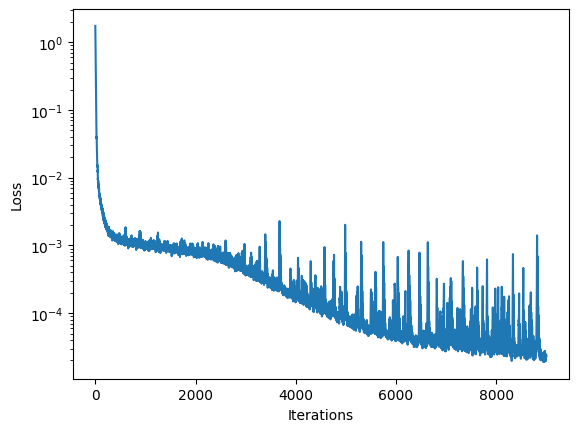

In [28]:
plt.semilogy(train_loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')

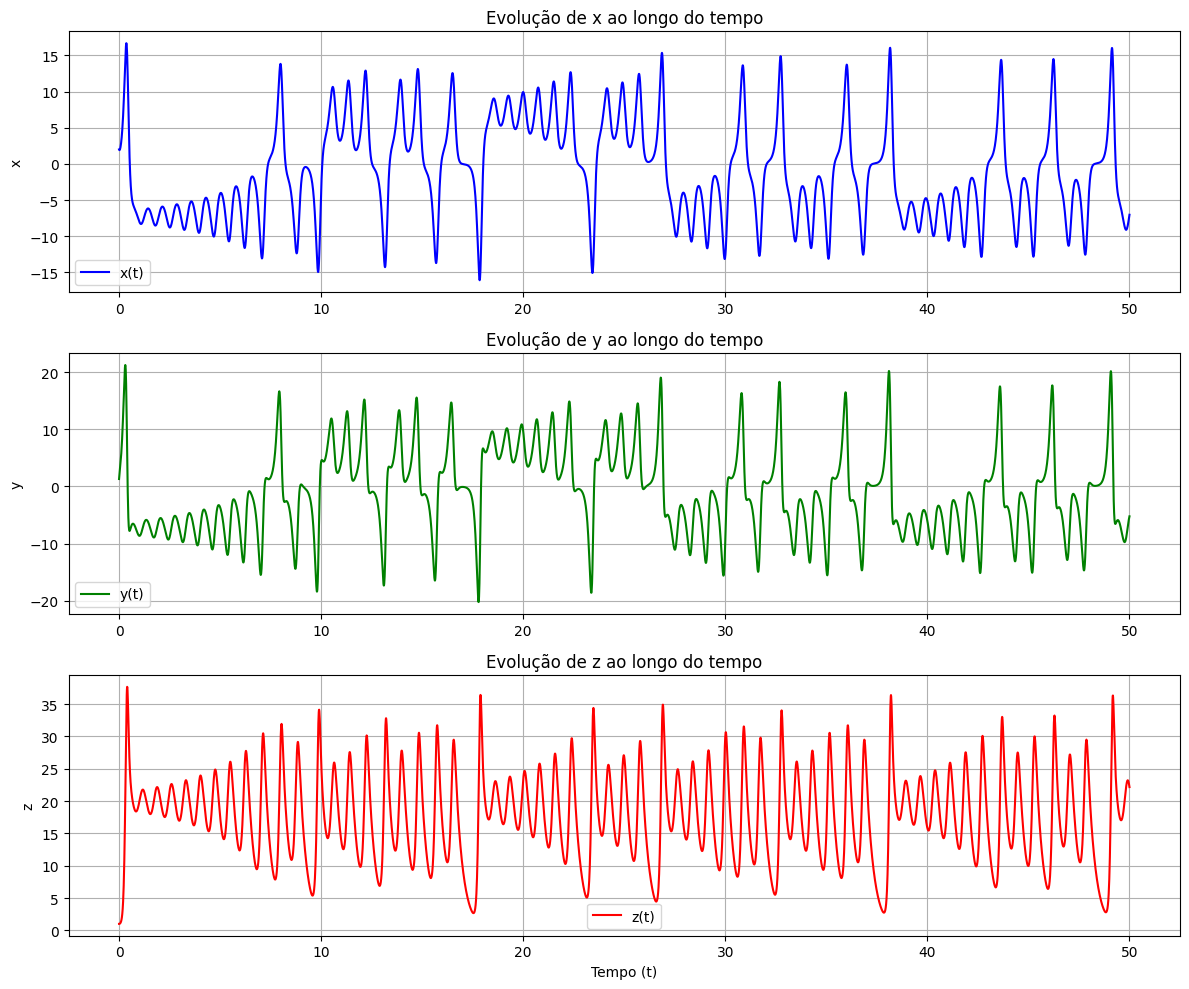

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Definindo o sistema de Lorenz
def lorenz_system(state, sigma=10, rho=21, beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

# Integração do sistema com o método de Euler
def integrate_lorenz(state, t_max=50, dt=0.01):
    num_steps = int(t_max / dt)
    states = np.empty((num_steps, 3))
    states[0] = state
    for i in range(1, num_steps):
        states[i] = states[i - 1] + lorenz_system(states[i - 1]) * dt
    return states

# Parâmetros iniciais e execução
initial_state = [2.0, 1.3, 1.0]  # Condições iniciais (x, y, z)
t_max = 50  # Tempo máximo de simulação
dt = 0.01  # Intervalo de tempo
states = integrate_lorenz(initial_state, t_max, dt)

# Criando a visualização em 2D
time = np.linspace(0, t_max, states.shape[0])

plt.figure(figsize=(12, 10))

# Gráfico para x
plt.subplot(3, 1, 1)
plt.plot(time, states[:, 0], label='x(t)', color='b')
plt.title('Evolução de x ao longo do tempo')
plt.ylabel('x')
plt.grid()
plt.legend()

# Gráfico para y
plt.subplot(3, 1, 2)
plt.plot(time, states[:, 1], label='y(t)', color='g')
plt.title('Evolução de y ao longo do tempo')
plt.ylabel('y')
plt.grid()
plt.legend()

# Gráfico para z
plt.subplot(3, 1, 3)
plt.plot(time, states[:, 2], label='z(t)', color='r')
plt.title('Evolução de z ao longo do tempo')
plt.ylabel('z')
plt.xlabel('Tempo (t)')
plt.grid()
plt.legend()

# Mostrar o gráfico
plt.tight_layout()
plt.show()
